In [1]:
import awkward as ak
import numpy as np
import hist
from coffea import processor, hist as chist
from coffea.nanoevents.methods import vector, candidate
import uproot
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.lookup_tools import extractor
import mplhep as hep
import matplotlib.pyplot as plt
import numba

import particle
from particle import Particle

dim = {
    'csc':{},
    'dt':{},
    'cms':{},
}

s = 1e2 #cm
dim['csc']['zmin'] = s * 5.5
dim['csc']['zmax'] = s * 10.
dim['csc']['rmin'] = s * 0.
dim['csc']['rmax'] = s * 7.
dim['dt']['zmin'] = s * 0.
dim['dt']['zmax'] = s * 6.5
dim['dt']['rmin'] = s * 4.
dim['dt']['rmax'] = s * 7.5

dim['cms']['zmin'] = s * 0.
dim['cms']['zmax'] = s * 12.
dim['cms']['rmin'] = s * 0.
dim['cms']['rmax'] = s * 8.


In [2]:
class MyProcessor(processor.ProcessorABC):
    def process(self, events):
        #dimensions of cms and muon subdetector region
        dim = {
            'csc':{},
            'dt':{},
            'cms':{},
        }

        s = 1e2 #cm
        dim['csc']['zmin'] = s * 5.5
        dim['csc']['zmax'] = s * 10.
        dim['csc']['rmin'] = s * 0.
        dim['csc']['rmax'] = s * 7.
        dim['dt']['zmin'] = s * 0.
        dim['dt']['zmax'] = s * 6.5
        dim['dt']['rmin'] = s * 4.
        dim['dt']['rmax'] = s * 7.5

        dim['cms']['zmin'] = s * 0.
        dim['cms']['zmax'] = s * 12.
        dim['cms']['rmin'] = s * 0.
        dim['cms']['rmax'] = s * 8.
        
        
        dataset = events.metadata['dataset']
        sumw = ak.sum(events.genWeight)

        out = {
                dataset: {
                            "entries": len(events),
                            "sumw": sumw,
                         }
              }
        
        def R(x, y):
            return np.sqrt(x**2 + y**2)
        
        #this is a dirty way of doing this
        if ak.any(events.gParticleId == 9900015): pid = 9900015
        if ak.any(events.gParticleId == 1000023): pid = 1000023            
        
        #makes mask of particles who's parent is an LLP
        llpPIDmomCut = (events.gParticleMotherId == pid)
        #takes care of multi counting by picking index of first True value in each column
        llpDaughterInd = ak.argmax(llpPIDmomCut, axis = 1, keepdims = True)
        llpMomInd = events.gParticleMotherIndex[llpDaughterInd]
        #llpMomInd = (events.gParticleId == 1000023)
        
        llps = ak.zip(
                        {
                            'X': events.gParticleProdVertexX[llpDaughterInd],
                            'Y': events.gParticleProdVertexY[llpDaughterInd],
                            'Z': events.gParticleProdVertexZ[llpDaughterInd], 
                            'R': R(events.gParticleProdVertexX[llpDaughterInd],
                                   events.gParticleProdVertexY[llpDaughterInd]),
                            'pt': events.gParticlePt[llpMomInd],
                            'phi': events.gParticlePhi[llpMomInd],
                            'eta': events.gParticleEta[llpMomInd],
                            'mass': ak.ones_like(events.gParticlePhi[llpMomInd]),
                            'E': events.gParticleE[llpMomInd],
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )

        cscs = ak.zip(
                        {
                            'X': events.cscRechitClusterX,
                            'Y': events.cscRechitClusterY,
                            'Z': events.cscRechitClusterZ, 
                            'R': R(events.cscRechitClusterX, events.cscRechitClusterY),
                            'pt': ak.ones_like(events.cscRechitClusterPhi),
                            'phi': events.cscRechitClusterPhi,
                            'eta': events.cscRechitClusterEta,
                            'mass': ak.ones_like(events.cscRechitClusterPhi),
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )
        
        cschits = ak.zip(
                        {
                            'X': events.cscRechitsX,
                            'Y': events.cscRechitsY,
                            'Z': events.cscRechitsZ,
                            'R': R(events.cscRechitsX, events.cscRechitsY),
                            'pt': ak.ones_like(events.cscRechitsPhi),
                            'phi': events.cscRechitsPhi,
                            'eta': events.cscRechitsEta,
                            'mass': ak.ones_like(events.cscRechitsPhi),
                            'E': ak.ones_like(events.cscRechitsPhi),
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )                
        
        dts = ak.zip(
                        {
                            'X': events.dtRechitClusterX,
                            'Y': events.dtRechitClusterY,
                            'Z': events.dtRechitClusterZ, 
                            'R': R(events.dtRechitClusterX, events.dtRechitClusterY),
                            'pt': ak.ones_like(events.dtRechitClusterPhi),
                            'phi': events.dtRechitClusterPhi,
                            'eta': events.dtRechitClusterEta,
                            'mass': ak.ones_like(events.dtRechitClusterPhi),
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )
        
        def cscCutter(p):
            cut = (
                    (abs(p.eta) < 2.4) & 
                    (abs(p.Z) > dim['csc']['zmin']) & (abs(p.Z) < dim['csc']['zmax']) &
                    (p.R < dim['csc']['rmax'])
                  )
            return p[cut]
        
        def dtCutter(p):
            cut = (
                    (p.R > dim['dt']['rmin']) & (p.R < dim['dt']['rmax']) &
                    (abs(p.Z) < dim['dt']['zmax'])
                  )
            return p[cut]
        
        #llps = llps[(llps.E > 50)]
        llpcscs = cscCutter(llps)
        llpdts = dtCutter(llps)
        #print(ak.min(llpcscs.E))
        
        #hist initializer
        def geo_hister(bins, region):
            return (
                    hist.Hist.new
                    .Reg(bins, dim[region]['zmin'], dim[region]['zmax'], name = 'z', label="z decay pos [cm]")
                    .Reg(bins, dim[region]['rmin'], dim[region]['rmax'], name = 'r', label="r decay pos [cm]")
                    .Double()
                   )
        
        bins = 30
        out[dataset]['genLLP'] = geo_hister(bins, region = 'cms')
        
        out[dataset]['genCSC'] = geo_hister(bins, region = 'cms')
        out[dataset]['genDT'] = geo_hister(bins, region = 'cms')

        out[dataset]['clsCSC'] = geo_hister(bins, region = 'cms')
        out[dataset]['clsDT'] = geo_hister(bins, region = 'cms')
        
        out[dataset]['hitCSC'] = geo_hister(bins, region = 'cms')
        out[dataset]['hitDT'] = geo_hister(bins, region = 'cms')
        
        out[dataset]['clsCSC_dRcut'] = geo_hister(bins, region = 'cms')
        out[dataset]['clsDT_dRcut'] = geo_hister(bins, region = 'cms')
        
        out[dataset]['hitCSC_dRcut'] = geo_hister(bins, region = 'cms')
        out[dataset]['hitDT_dRcut'] = geo_hister(bins, region = 'cms')
        
        def hister(bins, region, name, label):
            return (
                    hist.Hist.new
                    .Reg(bins, region[0], region[1], name = name, label = label)
                    .Double()
                   )            

        out[dataset]['dRCSC'] = hister(bins, [0,1], 'dR', 'dR')
        out[dataset]['dRDT'] = hister(bins, [0,1], 'dR', 'dR')
        
        out[dataset]['dRhitCSC'] = hister(bins, [0,1], 'dR', 'dR')
        out[dataset]['dRhitDT'] = hister(bins, [0,1], 'dR', 'dR')
        
        out[dataset]['ptCSC'] = hister(bins, [0,100], 'pt', 'pt [GeV]')
        out[dataset]['ptDT'] = hister(bins, [0,100], 'pt', 'pt [GeV]')
        
        out[dataset]['ECSC'] = hister(bins, [0,100], 'E', 'E [GeV]')
        out[dataset]['EDT'] = hister(bins, [0,100], 'E', 'E [GeV]')
        
        #hist filler
        def geo_filler(hist, p):
            z = abs(ak.flatten(p.Z, axis = None))
            r = ak.flatten(p.R, axis = None)
            hist.fill(z = z, r = r)
            
        #second argument is what is plotted
        def geo_filler_dRcut_helper(llps, clusts):
            clust_llp_pairs = ak.cartesian({"clusts": clusts, "llps": llps}, axis = 1, nested = True)
            delta_R = (clust_llp_pairs.clusts).delta_r(clust_llp_pairs.llps)
            matched = clust_llp_pairs.clusts[delta_R < 0.3]
            return abs(ak.flatten(matched.Z, None)), ak.flatten(matched.R, None), delta_R
            
        #last argument is what is plotted
        def geo_filler_dRcut(hist2d, hist1d, llps, clusts):
            z, r, dR = geo_filler_dRcut_helper(llps, clusts)
            hist2d.fill(z = z, r = r)
            hist1d.fill(dR = ak.flatten(dR, None))
            
        #second argument is what is plotted
        def geohit_filler_dRcut_helper(llps, clusts):
            clust_llp_pairs = ak.cartesian({"clusts": clusts, "llps": llps}, axis = 1, nested = True)
            delta_R = (clust_llp_pairs.clusts).delta_r(clust_llp_pairs.llps)
            matched = clust_llp_pairs.clusts[delta_R < 0.3]
            return abs(ak.flatten(matched.Z, None)), ak.flatten(matched.R, None), delta_R
            
        #last argument is what is plotted
        def geohit_filler_dRcut(hist2d, hist1d, llps, clusts):
            z, r, dR = geo_filler_dRcut_helper(llps, clusts)
            hist2d.fill(z = z, r = r)
            hist1d.fill(dR = ak.flatten(dR, None))

        def pt_filler(hist, p):
            hist.fill(ak.flatten(p.pt, None))
                  
        def E_filler(hist, p):
            hist.fill(ak.flatten(p.E, None))            
           
        geo_filler(out[dataset]['genLLP'], llps)
        geo_filler(out[dataset]['genCSC'], llpcscs)
        geo_filler(out[dataset]['genDT'], llpdts)
        geo_filler(out[dataset]['clsCSC'], cscs)
        geo_filler(out[dataset]['clsDT'], dts)
        
        geo_filler_dRcut(out[dataset]['clsCSC_dRcut'], out[dataset]['dRCSC'], llpcscs, cscs)
        geo_filler_dRcut(out[dataset]['clsDT_dRcut'], out[dataset]['dRDT'], llpdts, dts)
        
        pt_filler(out[dataset]['ptCSC'], llpcscs)
        pt_filler(out[dataset]['ptDT'], llpdts)
        
        E_filler(out[dataset]['ECSC'], llpcscs)
        E_filler(out[dataset]['EDT'], llpdts)
        
        geo_filler(out[dataset]['hitCSC'], cschits)
        #geo_filler(out[dataset]['clsDT'], dts)
        
        ## note that here I put llpcscs in the last argument because the last two aruments commute,
        ## except for the fact that the last argument is what is plotted
        geo_filler_dRcut(out[dataset]['hitCSC_dRcut'], out[dataset]['dRhitCSC'], cschits, llpcscs)
       #geo_filler_dRcut(out[dataset]['hitDT_dRcut'], out[dataset]['dRhitDT'], dthits, llpdts)
    
        return out

    def postprocess(self, accumulator):
        return accumulator

#digging up 
def rootAdds(directory):
    my_file = open(directory, "r")
    data = my_file.read().strip()
    data_into_list = data.split("\n")
    my_file.close()
    return data_into_list

In [10]:
out['hnl']['genCSC']

Hist(
  Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
  Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
  storage=Double()) # Sum: 554.0

In [3]:

fileset = {}
fileset['hnl'] = rootAdds('notebooks/Bplus/rootAdds/BToHNL_MuonAndHNLGenFilter_mHNL1p0_ctau1000.txt')
fileset['phi'] = rootAdds('notebooks/Bplus/rootAdds/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000.txt')

out = processor.run_uproot_job(
    fileset,
    treename = "ntuples/llp",
    processor_instance = MyProcessor(),
    executor = processor.futures_executor,
    executor_args = {"schema": BaseSchema, "workers": 6},
    maxchunks = 30,
)

out

Preprocessing:   0%|          | 0/818 [00:00<?, ?file/s]

Processing:   0%|          | 0/60 [00:00<?, ?chunk/s]

{'phi': {'hitDT': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Double()),
  'dRDT': Hist(Regular(30, 0, 1, name='dR', label='dR'), storage=Double()) # Sum: 14.0 (87.0 with flow),
  'hitDT_dRcut': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Double()),
  'dRhitCSC': Hist(Regular(30, 0, 1, name='dR', label='dR'), storage=Double()) # Sum: 64221.0 (531491.0 with flow),
  'dRhitDT': Hist(Regular(30, 0, 1, name='dR', label='dR'), storage=Double()),
  'genLLP': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 58269.0 (104432.0 with flow),
  'hitCSC_dRcut': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Do

In [4]:
def triplotter(g1, g2, g3, t1, t2, t3, t):
    figsize = (12*3,10)
    fig, ax = plt.subplots(1,3,figsize = figsize)
    hep.hist2dplot(g1, ax = ax[0])
    hep.hist2dplot(g2, ax = ax[1])
    hep.hist2dplot(g3, ax = ax[2])
    ax[0].set_title(t1)
    ax[1].set_title(t2)
    ax[2].set_title(t3)
    fig.tight_layout()
    fig.suptitle(t, y=1.02)    

/tmp/ipykernel_16543/1989833410.py:6: RuntimeWarning: invalid value encountered in true_divide
  test = np.nan_to_num(num.view() / den.view(), posinf=0, neginf=0)
/tmp/ipykernel_16543/1989833410.py:15: RuntimeWarning: invalid value encountered in true_divide
  test = np.nan_to_num(num.view() / den.view(), posinf=0, neginf=0)


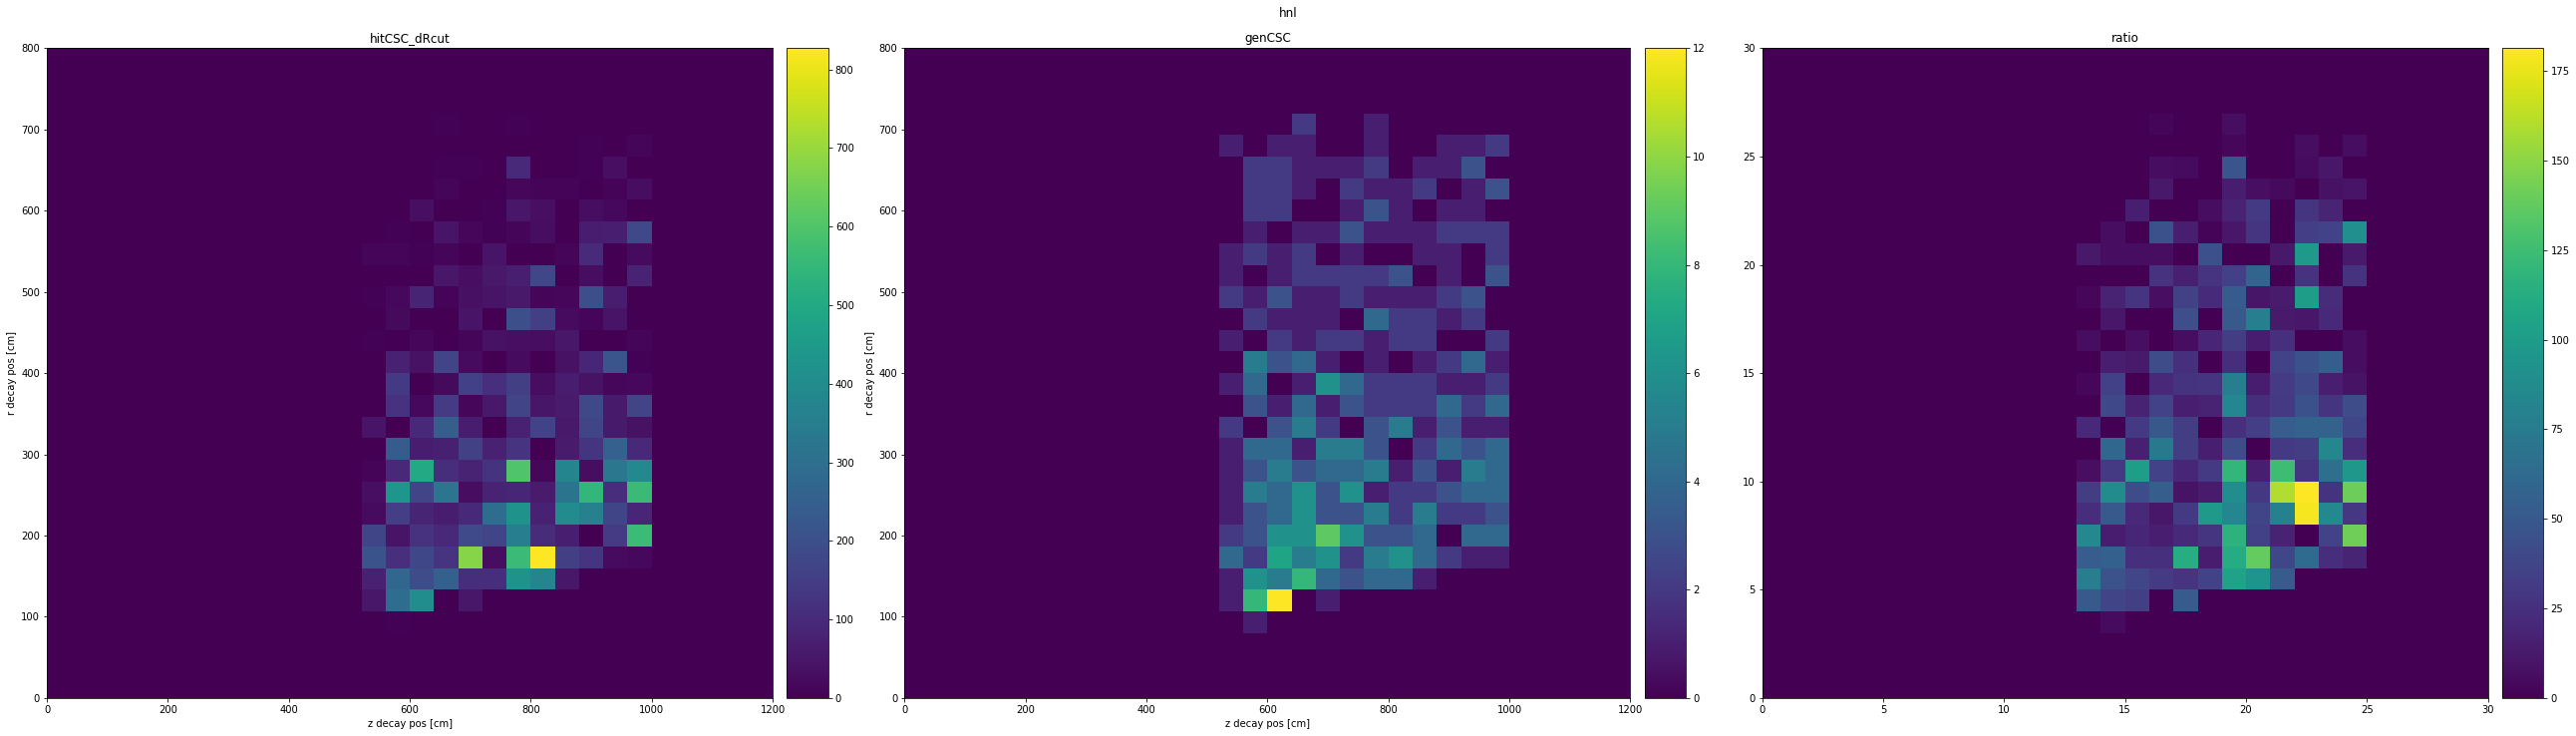

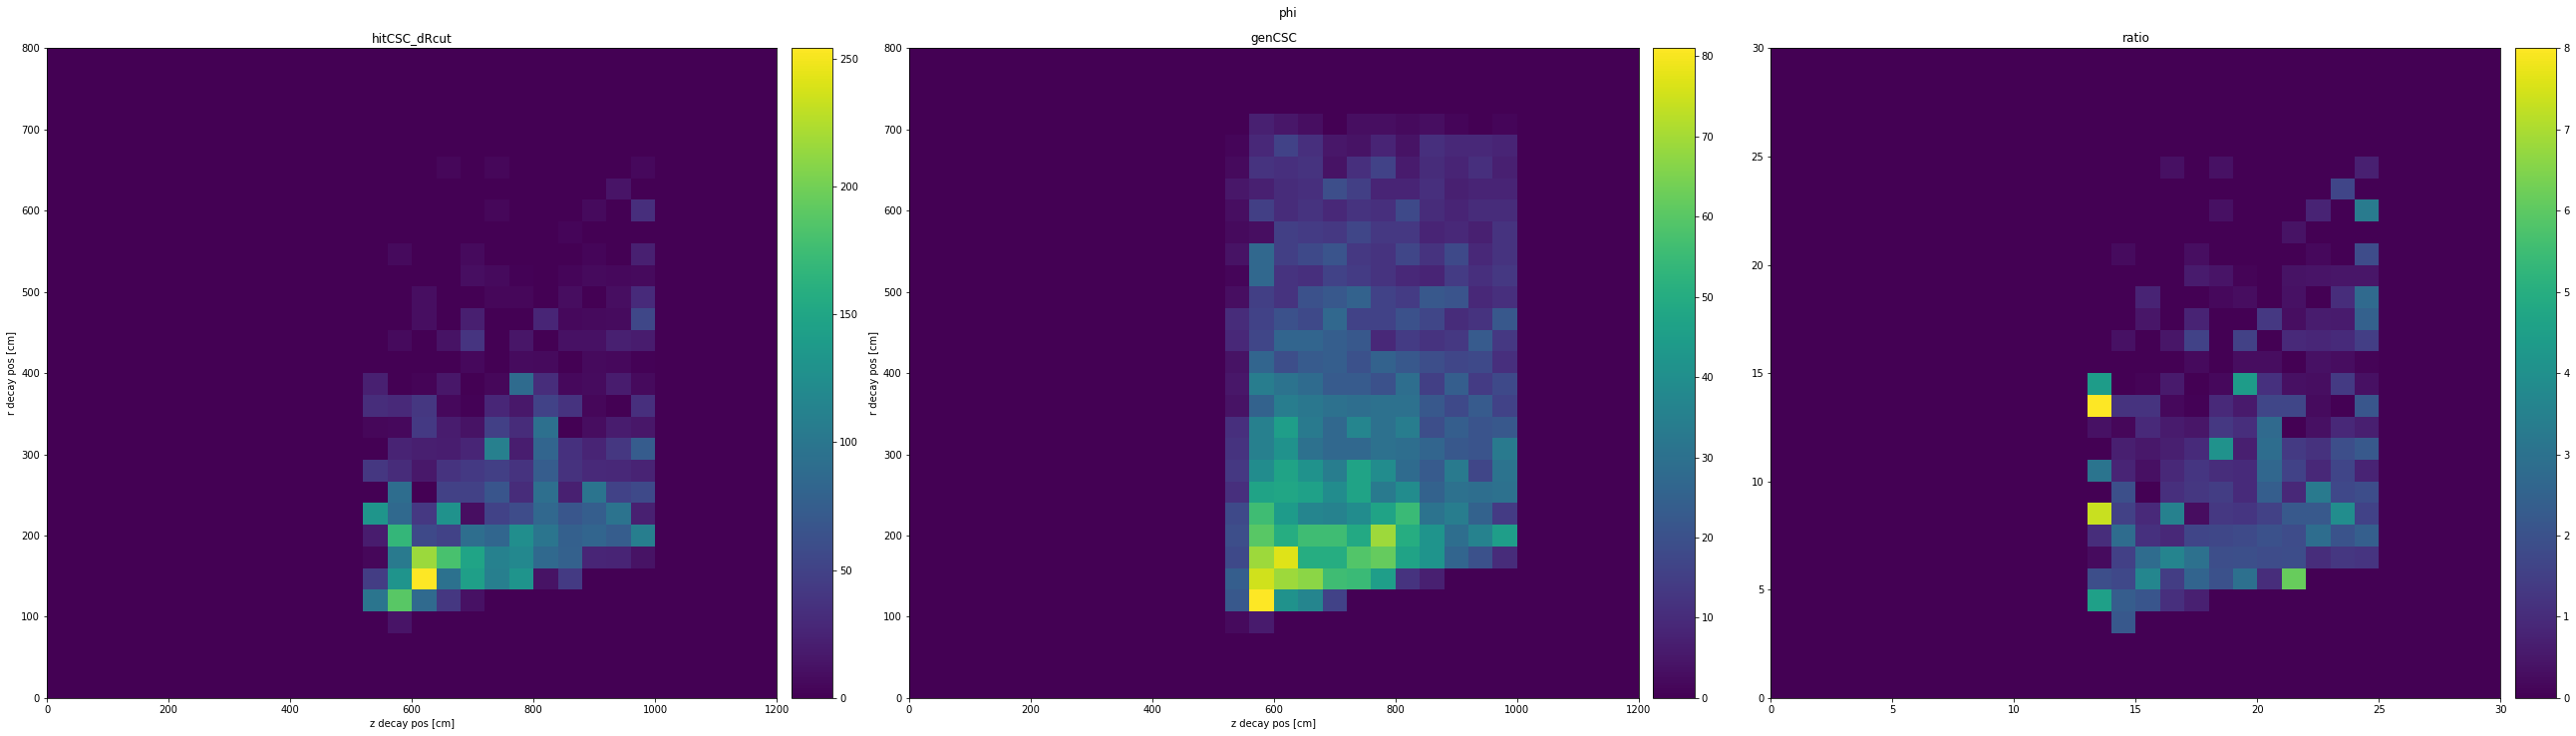

In [5]:
grp = 'hitCSC_dRcut'
proc = 'hnl'

num = out[proc][grp]
den = out[proc]['genCSC']
test = np.nan_to_num(num.view() / den.view(), posinf=0, neginf=0)

triplotter(num, den, test, grp, 'genCSC', 'ratio', proc)


proc = 'phi'

num = out[proc][grp]
den = out[proc]['genCSC']
test = np.nan_to_num(num.view() / den.view(), posinf=0, neginf=0)

triplotter(num, den, test, grp, 'genCSC', 'ratio', proc)


In [ ]:
g1 = 'clsCSC'
g2 = 'genCSC'
g3 = 'clsCSC_dRcut'
proc = 'hnl'

G1 = out[proc][g1]
G2 = out[proc][g2]
G3 = out[proc][g3]

triplotter(G1, G2, G3, g1, g2, g3, proc)

proc = 'phi'

G1 = out[proc][g1]
G2 = out[proc][g2]
G3 = out[proc][g3]

triplotter(G1, G2, G3, g1, g2, g3, proc)

In [ ]:
hep.style.use("CMS")
for junk in out:
    for jazz in out[junk]:
        if isinstance(out[junk][jazz], hist.Hist):
            fig, ax = plt.subplots()
            try:
                hep.hist2dplot(out[junk][jazz])
            except:
                hep.histplot(out[junk][jazz])
                ax.set_yscale('symlog')
            fig.suptitle(f'{jazz} {junk}')

In [ ]:
fig, ax = plt.subplots()
hep.histplot(out['hnl']['ptCSC'], label = 'hnl', density = True) 
hep.histplot(out['phi']['ptCSC'], label = 'phi', density = True)
ax.set_yscale('log')
ax.set_xlabel('pt [GeV]')
ax.set_title('pt')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim([0,100])
hep.histplot(out['hnl']['ECSC'], label = 'hnl', density = True) 
hep.histplot(out['phi']['ECSC'], label = 'phi', density = True)
ax.set_yscale('log')
ax.set_xlabel('E [GeV]')
ax.set_title('E')
plt.legend()
plt.show()

In [ ]:
import mplhep
from hist.intervals import ratio_uncertainty
import matplotlib.patches as patches

plt.style.use(mplhep.style.CMS)


def ratio(reco, real, rax, ax, det, proc):
    num = reco.project(ax)
    den = real.project(ax)
    rax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view(), "poisson"),
        #color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
        label = proc
        
    )
    rax.set_ylabel(f"{det} Cluster Efficiency")
    rax.set_xlabel(f"LLP decay {ax}[cm]")
    rax.legend()
    return rax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(550,1075)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax

def drawCSCr(ax):
    y_max = ax.get_ylim()[1]
    ax.axvline(350,linestyle="--",color='grey')
    ax.text(350-140,y_max*0.9, "Inner ring", fontsize=15)
    ax.text(350+15 ,y_max*0.9, "Outer ring", fontsize=15)
    return ax

sample = 'hnl'
print(sample)
figsize = (18,6)
fig, (cscrax, csczax) = plt.subplots(1,2,figsize = figsize)

llp = out[sample]['genCSC']
csc = out[sample]['clsCSC_dRcut']

ratio(csc, llp, csczax, 'z', 'csc', sample)
#drawCSCz(csczax)

ratio(csc, llp, cscrax, 'r', 'csc', sample)
#drawCSCr(cscrax)

sample = 'phi'

llp = out[sample]['genCSC']
csc = out[sample]['clsCSC_dRcut']

ratio(csc, llp, csczax, 'z', 'csc', sample)
drawCSCz(csczax)

ratio(csc, llp, cscrax, 'r', 'csc', sample)
drawCSCr(cscrax)


In [ ]:
#hnl
llppid = 9900015
filename = 'root://cmsxrootd.fnal.gov//store/group/lpclonglived/displacedJetMuonNtuple/V1p17/MC_Fall18/v2/BToHNL_MuonAndHNLGenFilter_mHNL1p0_ctau1000/Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_batch1_v1/220309_174743/0000/displacedJetMuon_ntupler_100.root'
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    treepath='ntuples/llp',
    entry_stop=10000,
    metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

part = []
pids = abs(ak.flatten(events.gParticleMotherId[abs(events.gParticleId) == 13]))
for i in np.unique(pids):
    try:
        junk = Particle.from_pdgid(i).name
        part.append(junk)
        print(junk)
    except:
        print(i)
        part.append(i)

fig, ax = plt.subplots(figsize = (16,8))
h = hist.Hist(hist.axis.IntCategory(np.unique(pids), label="PIDs"))
h.fill(pids)
plt.xticks(rotation=45)
plt.title('Muon Moms')
hep.histplot(h)

fig, ax = plt.subplots(figsize = (16,8))
h = (
    hist.Hist.new
    .Reg(30, 0, 600, name = 'n', label="n hits")
    .Double()
    )
h.fill((events.ncscRechits))
plt.ylabel('n clusters')
plt.title('ncscClusterHits')
hep.histplot(h)
plt.show()

temp = events[events.ncscRechits > 200]
fig, ax = plt.subplots(figsize = (64,8))
pids = abs(ak.flatten(temp.gParticleId))
h = hist.Hist(hist.axis.IntCategory(np.unique(pids), label="PIDs"))
h.fill(pids)
plt.xticks(rotation=45)
plt.title('event PIDs')
ax.set_yscale('log')
hep.histplot(h)
plt.show()

print(f'events with nhits > 200: {len(temp)}')
print(f'total llps: {ak.sum(pids == llppid)}')



llpPIDmomCut = (temp.gParticleMotherId == llppid)
llpDaughterInd = ak.argmax(llpPIDmomCut, axis = 1, keepdims = True)
llpMomInd = temp.gParticleMotherIndex[llpDaughterInd]

def R(x, y):
    return np.sqrt(x**2 + y**2)

def geo_hister(bins, region):
    return (
            hist.Hist.new
            .Reg(bins, dim[region]['zmin'], dim[region]['zmax'], name = 'z', label="z decay pos [cm]")
            .Reg(bins, dim[region]['rmin'], dim[region]['rmax'], name = 'r', label="r decay pos [cm]")
            .Double()
           )

llphist = geo_hister(30, 'cms')
cschist = geo_hister(30, 'cms')
                    
llps = ak.zip(
                {
                    'X': temp.gParticleProdVertexX[llpDaughterInd],
                    'Y': temp.gParticleProdVertexY[llpDaughterInd],
                    'Z': temp.gParticleProdVertexZ[llpDaughterInd], 
                    'R': R(temp.gParticleProdVertexX[llpDaughterInd],
                           temp.gParticleProdVertexY[llpDaughterInd]),
                    'pt': temp.gParticlePt[llpMomInd],
                    'phi': temp.gParticlePhi[llpMomInd],
                    'eta': temp.gParticleEta[llpMomInd],
                    'mass': ak.ones_like(temp.gParticlePhi[llpMomInd]),
                    'E': temp.gParticleE[llpMomInd],
                },
                with_name = 'PtEtaPhiMLorentzVector',
                behavior = vector.behavior,                 
              )

cscs = ak.zip(
                {
                    'X': temp.cscRechitClusterX,
                    'Y': temp.cscRechitClusterY,
                    'Z': temp.cscRechitClusterZ, 
                    'R': R(temp.cscRechitClusterX, temp.cscRechitClusterY),
                    'pt': ak.ones_like(temp.cscRechitClusterPhi),
                    'phi': temp.cscRechitClusterPhi,
                    'eta': temp.cscRechitClusterEta,
                    'mass': ak.ones_like(temp.cscRechitClusterPhi),
                    
                },
                with_name = 'PtEtaPhiMLorentzVector',
                behavior = vector.behavior,                 
              )


llphist.fill(z = abs(ak.flatten(llps.Z)), r = ak.flatten(llps.R))
cschist.fill(z = abs(ak.flatten(cscs.Z)), r = ak.flatten(cscs.R))

fig, ax = plt.subplots(figsize = (12,10))
plt.title('gLLP')
hep.hist2dplot(llphist)
plt.show()
fig, ax = plt.subplots(figsize = (12,10))
plt.title('cscClusters')
hep.hist2dplot(cschist)
plt.show()

In [ ]:
events.fields

In [ ]:
#phi
llppid = 1000023
filename = 'root://cmsxrootd.fnal.gov//store/group/lpclonglived/displacedJetMuonNtuple/V1p17/MC_Fall18/v2/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000/Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_batch1_v2/220307_223055/0000/displacedJetMuon_ntupler_100.root'
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    treepath='ntuples/llp',
    entry_stop=10000,
    metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

part = []
pids = abs(ak.flatten(events.gParticleMotherId[abs(events.gParticleId) == 13]))
for i in np.unique(pids):
    try:
        junk = Particle.from_pdgid(i).name
        part.append(junk)
        print(junk)
    except:
        print(i)
        part.append(i)

fig, ax = plt.subplots(figsize = (16,8))
h = hist.Hist(hist.axis.IntCategory(np.unique(pids), label="PIDs"))
h.fill(pids)
plt.xticks(rotation=45)
plt.title('Muon Moms')
hep.histplot(h)

fig, ax = plt.subplots(figsize = (16,8))
h = (
    hist.Hist.new
    .Reg(30, 0, 600, name = 'n', label="n hits")
    .Double()
    )
h.fill((events.ncscRechits))
plt.ylabel('n clusters')
plt.title('ncscClusterHits')
hep.histplot(h)
plt.show()

temp = events[events.ncscRechits > 200]
fig, ax = plt.subplots(figsize = (64,8))
pids = abs(ak.flatten(temp.gParticleId))
h = hist.Hist(hist.axis.IntCategory(np.unique(pids), label="PIDs"))
h.fill(pids)
plt.xticks(rotation=45)
plt.title('event PIDs')
ax.set_yscale('log')
hep.histplot(h)
plt.show()

print(f'events with nhits > 200: {len(temp)}')
print(f'total llps: {ak.sum(pids == llppid)}')



llpPIDmomCut = (temp.gParticleMotherId == llppid)
llpDaughterInd = ak.argmax(llpPIDmomCut, axis = 1, keepdims = True)
llpMomInd = temp.gParticleMotherIndex[llpDaughterInd]

def R(x, y):
    return np.sqrt(x**2 + y**2)

def geo_hister(bins, region):
    return (
            hist.Hist.new
            .Reg(bins, dim[region]['zmin'], dim[region]['zmax'], name = 'z', label="z decay pos [cm]")
            .Reg(bins, dim[region]['rmin'], dim[region]['rmax'], name = 'r', label="r decay pos [cm]")
            .Double()
           )

llphist = geo_hister(30, 'cms')
cschist = geo_hister(30, 'cms')
                    
llps = ak.zip(
                {
                    'X': temp.gParticleProdVertexX[llpDaughterInd],
                    'Y': temp.gParticleProdVertexY[llpDaughterInd],
                    'Z': temp.gParticleProdVertexZ[llpDaughterInd], 
                    'R': R(temp.gParticleProdVertexX[llpDaughterInd],
                           temp.gParticleProdVertexY[llpDaughterInd]),
                    'pt': temp.gParticlePt[llpMomInd],
                    'phi': temp.gParticlePhi[llpMomInd],
                    'eta': temp.gParticleEta[llpMomInd],
                    'mass': ak.ones_like(temp.gParticlePhi[llpMomInd]),
                    'E': temp.gParticleE[llpMomInd],
                },
                with_name = 'PtEtaPhiMLorentzVector',
                behavior = vector.behavior,                 
              )

cscs = ak.zip(
                {
                    'X': temp.cscRechitClusterX,
                    'Y': temp.cscRechitClusterY,
                    'Z': temp.cscRechitClusterZ, 
                    'R': R(temp.cscRechitClusterX, temp.cscRechitClusterY),
                    'pt': ak.ones_like(temp.cscRechitClusterPhi),
                    'phi': temp.cscRechitClusterPhi,
                    'eta': temp.cscRechitClusterEta,
                    'mass': ak.ones_like(temp.cscRechitClusterPhi),
                    
                },
                with_name = 'PtEtaPhiMLorentzVector',
                behavior = vector.behavior,                 
              )


llphist.fill(z = abs(ak.flatten(llps.Z)), r = ak.flatten(llps.R))
cschist.fill(z = abs(ak.flatten(cscs.Z)), r = ak.flatten(cscs.R))

fig, ax = plt.subplots(figsize = (12,10))
plt.title('gLLP')
hep.hist2dplot(llphist)
plt.show()
fig, ax = plt.subplots(figsize = (12,10))
plt.title('cscClusters')
hep.hist2dplot(cschist)
plt.show()

In [ ]:
llpPIDmomCut = (events.gParticleMotherId == llppid)
llpDaughterInd = ak.argmax(llpPIDmomCut, axis = 1, keepdims = True)
llpMomInd = events.gParticleMotherIndex[llpDaughterInd]


def R(x, y):
    return np.sqrt(x**2 + y**2)

llps = ak.zip(
                {
                    'X': events.gParticleProdVertexX[llpDaughterInd],
                    'Y': events.gParticleProdVertexY[llpDaughterInd],
                    'Z': events.gParticleProdVertexZ[llpDaughterInd], 
                    'R': R(events.gParticleProdVertexX[llpDaughterInd],
                           events.gParticleProdVertexY[llpDaughterInd]),
                    'pt': events.gParticlePt[llpMomInd],
                    'phi': events.gParticlePhi[llpMomInd],
                    'eta': events.gParticleEta[llpMomInd],
                    'mass': ak.ones_like(events.gParticlePhi[llpMomInd]),
                    'E': events.gParticleE[llpMomInd],
                },
                with_name = 'PtEtaPhiMLorentzVector',
                behavior = vector.behavior,                 
              )

cscs = ak.zip(
                {
                    'X': events.cscRechitClusterX,
                    'Y': events.cscRechitClusterY,
                    'Z': events.cscRechitClusterZ, 
                    'R': R(events.cscRechitClusterX, events.cscRechitClusterY),
                    'pt': ak.ones_like(events.cscRechitClusterPhi),
                    'phi': events.cscRechitClusterPhi,
                    'eta': events.cscRechitClusterEta,
                    'mass': ak.ones_like(events.cscRechitClusterPhi),
                    
                },
                with_name = 'PtEtaPhiMLorentzVector',
                behavior = vector.behavior,                 
              )

dts = ak.zip(
                {
                    'X': events.dtRechitClusterX,
                    'Y': events.dtRechitClusterY,
                    'Z': events.dtRechitClusterZ, 
                    'R': R(events.dtRechitClusterX, events.dtRechitClusterY),
                    'pt': ak.ones_like(events.dtRechitClusterPhi),
                    'phi': events.dtRechitClusterPhi,
                    'eta': events.dtRechitClusterEta,
                    'mass': ak.ones_like(events.dtRechitClusterPhi),
                },
                with_name = 'PtEtaPhiMLorentzVector',
                behavior = vector.behavior,                 
              )

cschits = ak.zip(
                {
                    'X': events.cscRechitsX,
                    'Y': events.cscRechitsY,
                    'Z': events.cscRechitsZ,
                    'R': R(events.cscRechitsX, events.cscRechitsY),
                    'pt': ak.ones_like(events.cscRechitsPhi),
                    'phi': events.cscRechitsPhi,
                    'eta': events.cscRechitsEta,
                    'mass': ak.ones_like(events.cscRechitsPhi),
                    'E': ak.ones_like(events.cscRechitsPhi),
                },
                with_name = 'PtEtaPhiMLorentzVector',
                behavior = vector.behavior,                 
              )  

In [ ]:
[k for k in events.fields if k.startswith('cscRechits')]

In [ ]:
llps.eta

In [ ]:
cscs.eta

In [ ]:
ak.mean(cschits.eta, axis = -1)

In [ ]:
#phi
llppid = 1000023
filename = 'root://cmsxrootd.fnal.gov//store/group/lpclonglived/displacedJetMuonNtuple/V1p17/MC_Fall18/v2/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000/Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_batch1_v2/220307_223055/0000/displacedJetMuon_ntupler_100.root'
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    treepath='ntuples/llp',
    entry_stop=10000,
    metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

def R(x, y):
    return np.sqrt(x**2 + y**2)

llpPIDmomCut = (events.gParticleMotherId == llppid)
llpDaughterInd = ak.argmax(llpPIDmomCut, axis = 1, keepdims = True)
llpMomInd = events.gParticleMotherIndex[llpDaughterInd]

llps = ak.zip(
                {
                    'X': events.gParticleProdVertexX[llpDaughterInd],
                    'Y': events.gParticleProdVertexY[llpDaughterInd],
                    'Z': events.gParticleProdVertexZ[llpDaughterInd], 
                    'R': R(events.gParticleProdVertexX[llpDaughterInd],
                           events.gParticleProdVertexY[llpDaughterInd]),
                    'pt': events.gParticlePt[llpMomInd],
                    'phi': events.gParticlePhi[llpMomInd],
                    'eta': events.gParticleEta[llpMomInd],
                    'mass': ak.ones_like(events.gParticlePhi[llpMomInd]),
                    'E': events.gParticleE[llpMomInd],
                },
                with_name = 'PtEtaPhiMLorentzVector',
                behavior = vector.behavior,                 
              )

In [ ]:
llps = 5
[b for b, a in locals().items() if a is llps][0]

In [ ]:
import itertools

x = ['a','b','c']
y = ['1','2','3']

for i, j  in itertools.combinations(x, r = 2):
    print(i, j)

In [ ]:
llppid = 1000023
filename = 'root://cmsxrootd.fnal.gov//store/group/lpclonglived/displacedJetMuonNtuple/V1p17/MC_Fall18/v2/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000/Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_batch1_v2/220307_223055/0000/displacedJetMuon_ntupler_100.root'
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    treepath='ntuples/llp',
    entry_stop=10000,
    metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

In [ ]:
ak.flatten(events.gParticleE[events.gParticleId == llppid], axis = None)